# Multi Object Detection 

<a name='0'></a>
## Packages



In [147]:
import argparse
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import scipy.io
import scipy.misc
import numpy as np
import pandas as pd
import PIL
from PIL import ImageFont, ImageDraw, Image
import tensorflow as tf
from tensorflow.python.framework.ops import EagerTensor

from tensorflow.keras.models import load_model
from yad2k.models.keras_yolo import yolo_head
from yad2k.utils.utils import draw_boxes, get_colors_for_classes, scale_boxes, read_classes, read_anchors, preprocess_image
import cv2
import os
from os import listdir

%matplotlib inline

<a name='2'></a>
##  YOLO

<a name='2-2'></a>
### Filtering with a Threshold on Class Scores

We're going to first apply a filter by thresholding, meaning we'll get rid of any box for which the class "score" is less than a chosen threshold. 

This model gives a total of 19x19x5x85 numbers, with each box described by 85 numbers. It's convenient to rearrange the (19,19,5,85) (or (19,19,425)) dimensional tensor into the following variables:  
- `box_confidence`: tensor of shape $(19, 19, 5, 1)$ containing $p_c$ (confidence probability that there's some object) for each of the 5 boxes predicted in each of the 19x19 cells.
- `boxes`: tensor of shape $(19, 19, 5, 4)$ containing the midpoint and dimensions $(b_x, b_y, b_h, b_w)$ for each of the 5 boxes in each cell.
- `box_class_probs`: tensor of shape $(19, 19, 5, 80)$ containing the "class probabilities" $(c_1, c_2, ... c_{80})$ for each of the 80 classes for each of the 5 boxes per cell.

<a name='ex-1'></a>
### yolo_filter_boxes

Implement `yolo_filter_boxes()`.
1. Computing box scores by doing the elementwise product. ($p \times c$).  
2. For each box, finding:
    - the index of the class with the maximum box score
    - the corresponding box score
3. Creating a mask by using a threshold. 

4. Using TensorFlow to apply the mask to `box_class_scores`, `boxes` and `box_classes` to filter out the boxes you don't want. 

In [179]:
def yolo_filter_boxes(boxes, box_confidence, box_class_probs, threshold = 0.6):
    """Filters YOLO boxes by thresholding on object and class confidence.
    
    Arguments:
        boxes -- tensor of shape (19, 19, 5, 4)
        box_confidence -- tensor of shape (19, 19, 5, 1)
        box_class_probs -- tensor of shape (19, 19, 5, 80)
        threshold -- real value, if [ highest class probability score < threshold],
                     then get rid of the corresponding box

    Returns:
        scores -- tensor of shape (None,), containing the class probability score for selected boxes
        boxes -- tensor of shape (None, 4), containing (b_x, b_y, b_h, b_w) coordinates of selected boxes
        classes -- tensor of shape (None,), containing the index of the class detected by the selected boxes
    """
    
    x = 10
    y = tf.constant(100)



    box_scores = box_class_probs*box_confidence
    


    box_classes = tf.math.argmax(box_scores,axis=-1)
    box_class_scores = tf.math.reduce_max(box_scores,axis=-1)

    filtering_mask = (box_class_scores >= threshold)
    
 
    scores = tf.boolean_mask(box_class_scores,filtering_mask)
    boxes = tf.boolean_mask(boxes,filtering_mask)
    classes = tf.boolean_mask(box_classes,filtering_mask)
    
    
    
    return scores, boxes, classes

In [180]:
def iou(box1, box2):
    """ intersection over union (IoU) between box1 and box2
    
    Arguments:
    box1 -- first box, list object with coordinates (box1_x1, box1_y1, box1_x2, box_1_y2)
    box2 -- second box, list object with coordinates (box2_x1, box2_y1, box2_x2, box2_y2)
    """


    (box1_x1, box1_y1, box1_x2, box1_y2) = box1
    (box2_x1, box2_y1, box2_x2, box2_y2) = box2

    


    xi1 = max(box1_x1,box2_x1)
    yi1 = max(box1_y1,box2_y1)
    xi2 = min(box1_x2,box2_x2)
    yi2 = min(box1_y2,box2_y2)
    inter_width = max(0,yi2 - yi1)
    inter_height = max(0,xi2 - xi1)
    inter_area = inter_width*inter_height

    box1_area = (box1_x2-box1_x1)*((box1_y2-box1_y1))
    box2_area = (box2_x2-box2_x1)*((box2_y2-box2_y1))
    union_area = box1_area + box2_area - inter_area

    iou = inter_area/union_area
    

    
    return iou

In [181]:
def yolo_non_max_suppression(scores, boxes, classes, max_boxes = 10, iou_threshold = 0.5):
    """
    Applies Non-max suppression (NMS) to set of boxes
    
    Arguments:
    scores -- tensor of shape (None,), output of yolo_filter_boxes()
    boxes -- tensor of shape (None, 4), output of yolo_filter_boxes() that have been scaled to the image size (see later)
    classes -- tensor of shape (None,), output of yolo_filter_boxes()
    max_boxes -- integer, maximum number of predicted boxes you'd like
    iou_threshold -- real value, "intersection over union" threshold used for NMS filtering
    
    Returns:
    scores -- tensor of shape (, None), predicted score for each box
    boxes -- tensor of shape (4, None), predicted box coordinates
    classes -- tensor of shape (, None), predicted class for each box
    
    Note: The "None" dimension of the output tensors has obviously to be less than max_boxes. Note also that this
    function will transpose the shapes of scores, boxes, classes. This is made for convenience.
    """
    
    max_boxes_tensor = tf.Variable(max_boxes, dtype='int32')     # tensor to be used in tf.image.non_max_suppression()

    nms_indices = tf.image.non_max_suppression(boxes,scores,max_boxes_tensor,iou_threshold)

    scores = tf.gather(scores,nms_indices)
    boxes = tf.gather(boxes,nms_indices)
    classes = tf.gather(classes,nms_indices)


    
    return scores, boxes, classes

In [182]:
def yolo_boxes_to_corners(box_xy, box_wh):
    """Converting YOLO box predictions to bounding box corners."""
    box_mins = box_xy - (box_wh / 2.)
    box_maxes = box_xy + (box_wh / 2.)

    return tf.keras.backend.concatenate([
        box_mins[..., 1:2],  # y_min
        box_mins[..., 0:1],  # x_min
        box_maxes[..., 1:2],  # y_max
        box_maxes[..., 0:1]  # x_max
    ])

In [183]:
def yolo_eval(yolo_outputs, image_shape = (720, 1280), max_boxes=10, score_threshold=.6, iou_threshold=.5):
    """
    Converts the output of YOLO encoding (a lot of boxes) to your predicted boxes along with their scores, box coordinates and classes.
    
    Arguments:
    yolo_outputs -- output of the encoding model (for image_shape of (608, 608, 3)), contains 4 tensors:
                    box_xy: tensor of shape (None, 19, 19, 5, 2)
                    box_wh: tensor of shape (None, 19, 19, 5, 2)
                    box_confidence: tensor of shape (None, 19, 19, 5, 1)
                    box_class_probs: tensor of shape (None, 19, 19, 5, 80)
    image_shape -- tensor of shape (2,) containing the input shape, in this notebook we use (608., 608.) (has to be float32 dtype)
    max_boxes -- integer, maximum number of predicted boxes you'd like
    score_threshold -- real value, if [ highest class probability score < threshold], then get rid of the corresponding box
    iou_threshold -- real value, "intersection over union" threshold used for NMS filtering
    
    Returns:
    scores -- tensor of shape (None, ), predicted score for each box
    boxes -- tensor of shape (None, 4), predicted box coordinates
    classes -- tensor of shape (None,), predicted class for each box
    """
    
    
    # Retrieve outputs of the YOLO model (≈1 line)
    box_xy, box_wh, box_confidence, box_class_probs = yolo_outputs

    # Convert boxes to be ready for filtering functions (convert boxes box_xy and box_wh to corner coordinates)
    boxes = yolo_boxes_to_corners(box_xy, box_wh)

    # Use one of the functions you've implemented to perform Score-filtering with a threshold of score_threshold (≈1 line)
    scores, boxes, classes = yolo_filter_boxes(boxes, box_confidence, box_class_probs, score_threshold)
    
    # Scale boxes back to original image shape (720, 1280 or whatever)
    boxes = scale_boxes(boxes, image_shape) # Network was trained to run on 608x608 images

    # Use one of the functions you've implemented to perform Non-max suppression with 
    # maximum number of boxes set to max_boxes and a threshold of iou_threshold (≈1 line)
    scores, boxes, classes = yolo_non_max_suppression(scores, boxes, classes, max_boxes, iou_threshold)

    
    return scores, boxes, classes

In [184]:
class_names = read_classes("model_data/coco_classes.txt")
anchors = read_anchors("model_data/yolo_anchors.txt")
model_image_size = (608, 608) # Same as yolo_model input layer size

In [185]:
yolo_model = load_model("model_data/yolo.h5", compile=False)

In [10]:
yolo_model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 608, 608, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 608, 608, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 608, 608, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 608, 608, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [197]:
def predict(image_file,print_info=False):
    """
    Runs the graph to predict boxes for "image_file". Prints and plots the predictions.
    
    Arguments:
    image_file -- name of an image stored in the "images" folder.
    
    Returns:
    out_scores -- tensor of shape (None, ), scores of the predicted boxes
    out_boxes -- tensor of shape (None, 4), coordinates of the predicted boxes
    out_classes -- tensor of shape (None, ), class index of the predicted boxes
    
 
    """

    # Preprocess your image
    image, image_data = preprocess_image("images/" + image_file, model_image_size = (608, 608))
    
    yolo_model_outputs = yolo_model(image_data) # It's output is of shape (m, 19, 19, 5, 85) 
    # But yolo_eval takes input a tensor contains 4 tensors: box_xy,box_wh, box_confidence & box_class_probs
    yolo_outputs = yolo_head(yolo_model_outputs, anchors, len(class_names))
    
    out_scores, out_boxes, out_classes = yolo_eval(yolo_outputs, [image.size[1],  image.size[0]], 10, 0.3, 0.5)
    if print_info:
        print('Found {} boxes for {}'.format(len(out_boxes), "images/" + image_file))
    # Generate colors for drawing bounding boxes.
    colors = get_colors_for_classes(len(class_names))
    # Draw bounding boxes on the image file
    #draw_boxes2(image, out_scores, out_boxes, out_classes, class_names, colors, image_shape)
    draw_boxes(image, out_boxes, out_classes, class_names, out_scores)
    # Save the predicted bounding box on the image
    image.save(os.path.join("out", str(image_file).split('.')[0]+"_annotated." +str(image_file).split('.')[1] ), quality=100)
    # Display the results in the notebook
    output_image = Image.open(os.path.join("out", str(image_file).split('.')[0]+"_annotated." +str(image_file).split('.')[1] ))
    imshow(output_image)

    return out_scores, out_boxes, out_classes

car 0.53 (320, 304) (386, 331)
car 0.49 (394, 295) (453, 318)
car 0.47 (765, 280) (828, 304)
traffic light 0.44 (411, 153) (433, 182)
traffic light 0.44 (1166, 5) (1275, 231)
car 0.38 (266, 301) (319, 325)
car 0.38 (308, 298) (403, 336)
car 0.36 (492, 295) (566, 320)
traffic light 0.35 (664, 203) (674, 224)
car 0.30 (410, 291) (450, 309)


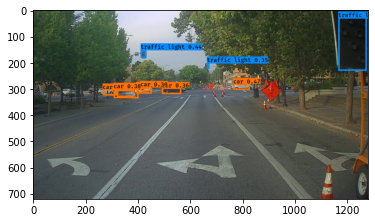

In [199]:
out_scores, out_boxes, out_classes = predict("0002.jpg")

## For Video

bus 0.67 (754, 17) (1280, 255)
car 0.65 (138, 258) (319, 547)
car 0.59 (173, 258) (577, 671)
car 0.58 (87, 261) (272, 474)
traffic light 0.52 (875, 41) (915, 85)
car 0.51 (67, 318) (155, 486)
car 0.46 (447, 181) (1249, 703)
car 0.43 (8, 299) (82, 417)
car 0.41 (882, 468) (1280, 720)
car 0.69 (176, 257) (577, 671)
bus 0.68 (751, 13) (1280, 260)
car 0.64 (84, 257) (274, 475)
car 0.62 (140, 260) (316, 538)
car 0.58 (399, 197) (1172, 691)
car 0.51 (63, 322) (157, 483)
traffic light 0.49 (872, 43) (911, 88)
car 0.38 (8, 296) (81, 418)
person 0.34 (675, 284) (760, 358)
train 0.69 (704, 21) (1280, 236)
car 0.65 (93, 267) (246, 473)
car 0.64 (170, 253) (572, 675)
car 0.64 (302, 194) (1111, 694)
car 0.43 (58, 316) (159, 482)
traffic light 0.42 (881, 42) (924, 85)
car 0.71 (194, 253) (555, 684)
car 0.70 (155, 304) (319, 564)
car 0.60 (402, 236) (768, 703)
car 0.56 (88, 256) (275, 470)
car 0.51 (480, 289) (689, 654)
bus 0.51 (762, 80) (1050, 246)
car 0.48 (200, 266) (375, 603)
car 0.47 (292, 354)

car 0.72 (153, 300) (324, 566)
car 0.69 (190, 251) (556, 687)
car 0.62 (393, 238) (775, 704)
car 0.55 (90, 255) (275, 467)
car 0.54 (65, 331) (162, 476)
car 0.48 (474, 295) (688, 651)
car 0.48 (295, 348) (438, 669)
car 0.43 (531, 211) (1035, 716)
car 0.43 (366, 275) (506, 671)
truck 0.42 (773, 62) (1063, 221)
car 0.74 (155, 299) (322, 569)
car 0.66 (201, 247) (532, 627)
car 0.61 (391, 237) (774, 703)
car 0.57 (65, 328) (162, 479)
car 0.56 (91, 255) (271, 469)
car 0.49 (473, 291) (688, 653)
car 0.47 (295, 350) (436, 668)
car 0.44 (205, 262) (381, 607)
car 0.42 (368, 277) (506, 669)
car 0.42 (537, 207) (1030, 717)
car 0.75 (154, 298) (319, 570)
car 0.70 (193, 250) (554, 688)
car 0.62 (394, 236) (775, 704)
car 0.58 (64, 328) (162, 480)
car 0.52 (89, 254) (274, 469)
car 0.47 (270, 283) (463, 664)
car 0.45 (475, 295) (687, 649)
car 0.44 (533, 208) (1034, 717)
car 0.44 (202, 262) (380, 608)
car 0.40 (366, 272) (508, 674)
car 0.74 (153, 301) (321, 568)
car 0.67 (190, 252) (556, 686)
car 0.60 

car 0.77 (160, 301) (321, 568)
car 0.64 (183, 245) (558, 693)
car 0.63 (536, 209) (1026, 714)
car 0.56 (391, 237) (774, 704)
car 0.53 (383, 313) (479, 714)
car 0.51 (65, 329) (165, 477)
car 0.51 (88, 256) (272, 467)
car 0.49 (286, 343) (435, 677)
car 0.47 (475, 295) (684, 649)
car 0.46 (204, 265) (378, 604)
car 0.77 (162, 301) (322, 568)
car 0.70 (187, 246) (556, 692)
car 0.67 (533, 212) (1027, 712)
car 0.55 (65, 330) (165, 477)
car 0.55 (283, 337) (439, 683)
car 0.55 (387, 239) (780, 703)
car 0.54 (384, 307) (479, 720)
car 0.53 (475, 297) (684, 648)
car 0.52 (91, 257) (272, 466)
car 0.47 (202, 267) (380, 602)
car 0.77 (181, 255) (550, 664)
car 0.67 (392, 190) (1026, 696)
bus 0.62 (767, 23) (1273, 247)
traffic light 0.50 (880, 44) (922, 91)
car 0.45 (36, 298) (167, 481)
car 0.44 (813, 169) (1257, 701)
car 0.39 (97, 275) (245, 504)
car 0.37 (6, 298) (90, 434)
car 0.34 (162, 260) (310, 607)
car 0.78 (160, 303) (320, 566)
car 0.66 (540, 212) (1021, 712)
car 0.62 (189, 247) (553, 692)
car 

car 0.77 (164, 292) (316, 577)
car 0.72 (196, 251) (548, 691)
car 0.60 (84, 258) (269, 467)
car 0.55 (478, 298) (682, 648)
car 0.51 (378, 300) (478, 720)
car 0.51 (64, 330) (167, 478)
bus 0.49 (762, 87) (1049, 244)
truck 0.47 (571, 104) (1269, 701)
car 0.46 (204, 263) (377, 606)
car 0.42 (380, 236) (787, 706)
car 0.75 (163, 290) (319, 579)
car 0.66 (194, 249) (549, 692)
car 0.54 (478, 296) (681, 651)
car 0.53 (86, 259) (267, 465)
car 0.50 (381, 301) (481, 720)
bus 0.48 (764, 88) (1047, 245)
car 0.48 (209, 260) (370, 609)
car 0.45 (515, 222) (1044, 708)
car 0.45 (65, 329) (164, 478)
car 0.40 (386, 236) (781, 707)
car 0.76 (166, 291) (317, 580)
car 0.74 (195, 245) (548, 696)
car 0.58 (84, 259) (268, 465)
car 0.53 (480, 298) (682, 650)
car 0.53 (561, 215) (1120, 710)
car 0.51 (382, 297) (479, 720)
car 0.46 (291, 319) (445, 703)
bus 0.46 (764, 84) (1051, 245)
car 0.43 (124, 252) (489, 554)
car 0.40 (201, 261) (378, 610)
car 0.78 (165, 299) (318, 573)
car 0.75 (198, 248) (545, 696)
car 0.62

car 0.79 (164, 301) (321, 566)
car 0.73 (190, 253) (553, 689)
car 0.59 (401, 236) (771, 704)
car 0.54 (382, 303) (475, 720)
car 0.53 (459, 162) (1094, 715)
car 0.52 (96, 262) (267, 459)
truck 0.47 (1016, 19) (1235, 163)
car 0.46 (199, 274) (378, 595)
truck 0.43 (772, 71) (1069, 214)
car 0.40 (422, 257) (605, 691)
car 0.79 (164, 303) (322, 567)
car 0.67 (182, 249) (559, 690)
car 0.59 (401, 236) (771, 703)
car 0.56 (457, 166) (1097, 711)
car 0.54 (385, 300) (478, 720)
car 0.51 (96, 261) (270, 461)
car 0.50 (200, 276) (378, 593)
truck 0.46 (1016, 25) (1227, 163)
truck 0.44 (772, 72) (1064, 212)
car 0.44 (420, 260) (601, 687)
car 0.79 (162, 300) (321, 571)
car 0.70 (186, 250) (552, 688)
car 0.60 (402, 239) (766, 700)
car 0.58 (383, 302) (477, 720)
car 0.54 (201, 273) (375, 597)
motorbike 0.53 (557, 145) (1243, 709)
car 0.50 (95, 262) (272, 457)
truck 0.45 (1012, 18) (1231, 163)
car 0.45 (267, 292) (473, 654)
car 0.44 (419, 257) (607, 691)
bus 0.76 (756, 14) (1280, 252)
car 0.68 (88, 255) (

car 0.77 (157, 296) (320, 574)
car 0.67 (196, 243) (541, 632)
car 0.62 (402, 240) (768, 695)
car 0.51 (385, 326) (474, 704)
car 0.50 (90, 257) (270, 465)
car 0.46 (68, 334) (164, 472)
motorbike 0.45 (585, 150) (1225, 706)
car 0.39 (207, 263) (374, 607)
car 0.39 (280, 297) (447, 651)
truck 0.39 (774, 74) (1059, 211)
car 0.77 (156, 296) (322, 573)
car 0.68 (197, 244) (537, 629)
car 0.60 (399, 237) (770, 701)
car 0.52 (386, 322) (476, 709)
car 0.51 (101, 277) (242, 502)
car 0.48 (80, 363) (160, 483)
car 0.46 (583, 77) (1238, 648)
car 0.42 (206, 262) (376, 606)
car 0.41 (416, 263) (610, 685)
car 0.41 (279, 297) (443, 650)
car 0.76 (156, 300) (321, 569)
car 0.71 (200, 247) (538, 628)
car 0.64 (404, 237) (768, 700)
car 0.54 (396, 380) (477, 720)
car 0.51 (91, 258) (266, 466)
car 0.47 (586, 75) (1236, 650)
car 0.45 (366, 275) (503, 669)
car 0.43 (67, 334) (163, 471)
car 0.40 (206, 263) (378, 606)
car 0.39 (277, 286) (454, 658)
car 0.77 (154, 299) (321, 573)
car 0.69 (201, 246) (537, 628)
car 

car 0.74 (159, 285) (318, 587)
car 0.69 (200, 247) (536, 628)
motorbike 0.58 (497, 155) (1171, 704)
car 0.52 (396, 380) (481, 720)
car 0.52 (97, 277) (252, 502)
bus 0.52 (754, 78) (1039, 244)
car 0.52 (403, 239) (770, 695)
car 0.49 (209, 260) (375, 612)
car 0.48 (76, 359) (160, 489)
car 0.45 (91, 251) (368, 472)
car 0.76 (158, 284) (319, 589)
car 0.71 (203, 248) (531, 629)
motorbike 0.61 (398, 153) (1148, 718)
car 0.53 (387, 323) (477, 709)
car 0.47 (402, 237) (768, 696)
car 0.47 (72, 360) (160, 486)
car 0.44 (95, 251) (366, 472)
car 0.44 (99, 274) (247, 504)
car 0.44 (207, 259) (372, 612)
bus 0.40 (759, 75) (1038, 247)
car 0.75 (157, 285) (321, 590)
car 0.73 (200, 248) (535, 627)
motorbike 0.58 (475, 166) (1186, 699)
car 0.53 (88, 252) (375, 471)
car 0.48 (391, 238) (781, 697)
car 0.47 (398, 376) (486, 720)
car 0.45 (205, 257) (377, 613)
car 0.45 (70, 361) (160, 485)
car 0.40 (100, 279) (248, 499)
bus 0.40 (759, 79) (1041, 245)
car 0.74 (155, 289) (320, 583)
car 0.70 (201, 249) (533, 

car 0.86 (434, 228) (843, 703)
car 0.82 (195, 258) (552, 677)
car 0.63 (136, 260) (333, 533)
car 0.61 (703, 174) (1236, 696)
car 0.61 (3, 307) (80, 415)
car 0.57 (99, 278) (254, 498)
traffic light 0.45 (878, 44) (920, 88)
train 0.43 (671, 28) (1280, 240)
car 0.43 (363, 276) (522, 678)
car 0.36 (65, 330) (157, 478)
car 0.77 (160, 298) (322, 581)
car 0.71 (196, 246) (534, 629)
car 0.67 (402, 215) (868, 711)
car 0.53 (94, 257) (272, 465)
car 0.53 (69, 334) (166, 479)
car 0.49 (389, 389) (478, 710)
car 0.48 (200, 264) (383, 606)
car 0.46 (362, 277) (506, 667)
motorbike 0.42 (456, 163) (1206, 696)
car 0.39 (290, 356) (433, 657)
car 0.76 (160, 296) (320, 579)
car 0.75 (199, 247) (533, 629)
car 0.65 (404, 216) (865, 712)
car 0.54 (91, 257) (272, 467)
car 0.53 (68, 331) (165, 481)
car 0.51 (391, 384) (475, 713)
car 0.47 (363, 274) (507, 670)
car 0.45 (199, 264) (383, 606)
motorbike 0.45 (459, 161) (1205, 696)
car 0.40 (293, 354) (432, 659)
car 0.77 (161, 297) (320, 578)
car 0.74 (200, 247) (53

car 0.74 (158, 297) (317, 573)
car 0.74 (201, 247) (536, 628)
car 0.64 (399, 219) (875, 707)
car 0.59 (67, 332) (165, 479)
car 0.55 (88, 255) (264, 467)
car 0.50 (386, 380) (477, 715)
motorbike 0.47 (451, 161) (1209, 697)
car 0.44 (206, 264) (379, 606)
car 0.36 (361, 277) (507, 665)
car 0.36 (278, 296) (449, 649)
car 0.74 (156, 299) (316, 573)
car 0.73 (200, 250) (538, 625)
car 0.64 (397, 220) (876, 708)
car 0.59 (67, 331) (166, 480)
car 0.57 (88, 256) (263, 467)
motorbike 0.48 (457, 156) (1206, 703)
car 0.45 (389, 378) (476, 717)
car 0.42 (208, 267) (376, 603)
car 0.36 (282, 302) (448, 643)
car 0.35 (361, 284) (502, 659)
car 0.75 (156, 300) (318, 572)
car 0.72 (198, 247) (542, 626)
car 0.62 (398, 221) (874, 707)
car 0.60 (67, 331) (165, 479)
car 0.54 (92, 256) (267, 468)
car 0.50 (388, 379) (477, 716)
motorbike 0.50 (456, 158) (1205, 701)
car 0.44 (210, 267) (375, 603)
car 0.37 (283, 302) (447, 644)
car 0.37 (362, 282) (499, 661)
car 0.75 (199, 250) (540, 624)
car 0.74 (155, 300) (319

car 0.73 (193, 250) (542, 624)
car 0.72 (154, 304) (318, 564)
car 0.63 (370, 177) (902, 714)
car 0.59 (88, 246) (374, 475)
car 0.59 (66, 331) (166, 481)
car 0.52 (203, 270) (385, 599)
car 0.49 (386, 383) (472, 715)
car 0.42 (104, 281) (246, 498)
car 0.39 (292, 364) (437, 652)
car 0.35 (753, 53) (1044, 226)
car 0.73 (194, 251) (542, 623)
car 0.71 (154, 304) (317, 563)
car 0.64 (398, 220) (874, 707)
car 0.61 (66, 330) (166, 481)
car 0.57 (90, 249) (375, 475)
car 0.54 (202, 267) (386, 600)
car 0.47 (386, 382) (473, 717)
motorbike 0.44 (471, 165) (1191, 695)
car 0.40 (290, 361) (439, 652)
car 0.40 (102, 281) (244, 499)
car 0.84 (428, 221) (823, 707)
car 0.83 (201, 257) (545, 680)
car 0.70 (161, 281) (325, 589)
car 0.70 (2, 307) (80, 413)
car 0.61 (97, 275) (252, 499)
car 0.55 (365, 273) (519, 678)
car 0.45 (384, 182) (1162, 701)
car 0.44 (84, 249) (374, 478)
traffic light 0.42 (876, 46) (915, 89)
car 0.41 (396, 387) (489, 709)
car 0.73 (193, 252) (540, 622)
car 0.71 (155, 299) (321, 568)
c

car 0.69 (193, 257) (542, 615)
car 0.69 (154, 307) (324, 562)
car 0.65 (386, 228) (892, 703)
car 0.60 (75, 255) (264, 470)
car 0.49 (200, 277) (386, 591)
car 0.41 (385, 325) (482, 703)
car 0.34 (339, 102) (1221, 699)
car 0.32 (275, 319) (459, 626)
car 0.70 (153, 311) (318, 559)
car 0.65 (387, 229) (886, 704)
car 0.65 (197, 256) (541, 617)
car 0.62 (75, 255) (261, 468)
car 0.55 (168, 245) (424, 551)
motorbike 0.34 (471, 168) (1189, 687)
car 0.69 (156, 308) (320, 564)
car 0.60 (73, 255) (259, 468)
car 0.59 (373, 227) (905, 704)
car 0.58 (193, 252) (544, 621)
car 0.52 (203, 280) (384, 590)
car 0.33 (136, 257) (449, 476)
motorbike 0.31 (467, 164) (1192, 691)
car 0.71 (154, 312) (319, 559)
car 0.65 (52, 258) (206, 470)
car 0.62 (166, 246) (431, 547)
car 0.59 (382, 228) (896, 704)
car 0.41 (94, 256) (371, 476)
car 0.40 (91, 275) (247, 501)
motorbike 0.38 (462, 165) (1197, 688)
car 0.33 (251, 297) (487, 573)
car 0.72 (152, 311) (322, 558)
car 0.67 (65, 256) (260, 466)
car 0.62 (166, 250) (432

car 0.82 (197, 250) (547, 685)
car 0.74 (417, 242) (764, 696)
car 0.69 (158, 275) (324, 595)
car 0.66 (663, 168) (1271, 699)
car 0.63 (4, 310) (80, 411)
car 0.56 (87, 263) (265, 474)
car 0.56 (359, 263) (521, 688)
car 0.50 (375, 185) (1036, 703)
car 0.48 (391, 379) (499, 717)
train 0.40 (723, 27) (1251, 242)
car 0.77 (14, 256) (224, 463)
car 0.71 (145, 305) (320, 565)
car 0.54 (392, 219) (872, 717)
car 0.52 (256, 267) (491, 608)
car 0.51 (183, 253) (568, 685)
car 0.45 (210, 266) (376, 606)
car 0.41 (368, 276) (499, 669)
car 0.39 (338, 92) (1232, 707)
car 0.31 (404, 373) (481, 720)
car 0.30 (290, 340) (424, 670)
car 0.78 (12, 256) (222, 462)
car 0.69 (146, 305) (320, 565)
car 0.58 (198, 252) (540, 624)
car 0.53 (382, 239) (783, 703)
car 0.45 (276, 296) (452, 650)
car 0.45 (175, 248) (403, 558)
car 0.43 (368, 278) (499, 666)
car 0.40 (345, 96) (1225, 703)
car 0.39 (468, 287) (684, 659)
car 0.80 (13, 254) (220, 465)
car 0.69 (146, 306) (322, 561)
car 0.56 (192, 254) (543, 621)
car 0.56 (3

car 0.80 (0, 266) (181, 460)
car 0.76 (136, 271) (362, 534)
car 0.63 (192, 258) (556, 684)
car 0.60 (392, 235) (774, 707)
car 0.54 (467, 283) (682, 663)
truck 0.45 (725, 38) (1099, 234)
motorbike 0.44 (463, 162) (1203, 694)
car 0.42 (246, 287) (494, 583)
car 0.35 (392, 292) (480, 720)
car 0.76 (137, 268) (363, 537)
car 0.76 (0, 267) (180, 459)
car 0.63 (384, 233) (783, 707)
car 0.62 (179, 260) (570, 682)
car 0.53 (466, 279) (684, 666)
truck 0.49 (727, 35) (1100, 235)
motorbike 0.46 (458, 164) (1208, 693)
car 0.42 (224, 269) (523, 536)
car 0.36 (267, 305) (449, 638)
car 0.33 (386, 301) (479, 720)
car 0.75 (138, 267) (361, 538)
car 0.64 (0, 267) (178, 458)
car 0.64 (387, 238) (782, 702)
car 0.61 (177, 261) (572, 681)
car 0.49 (464, 284) (683, 661)
motorbike 0.42 (456, 165) (1211, 691)
truck 0.42 (731, 39) (1092, 228)
car 0.38 (223, 271) (520, 533)
car 0.38 (265, 302) (446, 641)
car 0.33 (390, 302) (481, 720)
car 0.75 (1, 268) (176, 461)
car 0.74 (138, 265) (361, 537)
car 0.64 (188, 259) 

car 0.84 (3, 276) (162, 448)
car 0.76 (143, 264) (361, 540)
car 0.67 (401, 231) (760, 700)
car 0.64 (136, 251) (486, 613)
car 0.59 (378, 327) (473, 702)
car 0.52 (265, 309) (464, 645)
motorbike 0.33 (468, 162) (1198, 693)
car 0.84 (4, 276) (163, 446)
car 0.78 (143, 265) (360, 539)
car 0.65 (397, 233) (765, 697)
car 0.57 (268, 308) (459, 646)
car 0.56 (378, 330) (472, 700)
car 0.55 (135, 251) (488, 613)
car 0.34 (464, 279) (689, 655)
truck 0.30 (724, 44) (1101, 232)
car 0.84 (5, 274) (159, 446)
car 0.79 (143, 263) (353, 541)
car 0.60 (397, 232) (766, 699)
car 0.56 (359, 287) (506, 657)
car 0.56 (268, 310) (459, 642)
car 0.54 (179, 253) (542, 626)
motorbike 0.34 (458, 159) (1207, 694)
car 0.83 (5, 277) (155, 443)
car 0.79 (142, 259) (357, 543)
car 0.66 (395, 234) (761, 696)
car 0.58 (359, 284) (507, 662)
car 0.57 (178, 253) (538, 627)
car 0.43 (266, 307) (463, 644)
motorbike 0.32 (602, 115) (1212, 683)
car 0.31 (133, 284) (191, 363)
car 0.84 (1, 278) (155, 447)
car 0.78 (139, 257) (354, 

car 0.83 (119, 260) (359, 535)
car 0.76 (0, 268) (75, 442)
car 0.73 (145, 250) (462, 619)
car 0.70 (390, 238) (746, 699)
motorbike 0.63 (605, 112) (1203, 685)
car 0.58 (48, 287) (144, 356)
car 0.50 (224, 315) (417, 623)
car 0.84 (445, 224) (813, 705)
car 0.75 (210, 249) (519, 626)
car 0.71 (163, 290) (318, 583)
car 0.63 (379, 333) (490, 698)
car 0.58 (6, 313) (79, 406)
car 0.55 (289, 353) (440, 668)
car 0.53 (621, 175) (1208, 699)
car 0.50 (90, 252) (372, 471)
train 0.49 (724, 23) (1252, 242)
car 0.41 (203, 256) (375, 613)
car 0.83 (123, 259) (366, 534)
car 0.75 (0, 267) (73, 446)
car 0.73 (379, 236) (759, 696)
car 0.71 (183, 270) (437, 596)
car 0.53 (46, 294) (145, 360)
motorbike 0.51 (601, 117) (1206, 681)
car 0.49 (276, 311) (447, 636)
car 0.35 (394, 322) (628, 714)
car 0.82 (125, 255) (357, 539)
car 0.78 (383, 235) (754, 695)
car 0.75 (0, 264) (68, 450)
car 0.72 (242, 266) (471, 613)
motorbike 0.55 (603, 119) (1203, 680)
car 0.51 (43, 294) (142, 359)
car 0.81 (126, 255) (347, 540)


car 0.81 (356, 247) (683, 687)
car 0.80 (119, 259) (363, 525)
car 0.71 (183, 270) (429, 603)
motorbike 0.65 (600, 110) (1206, 686)
car 0.56 (15, 304) (109, 361)
car 0.54 (296, 299) (428, 648)
truck 0.49 (746, 56) (1088, 228)
car 0.44 (8, 306) (87, 402)
car 0.38 (121, 280) (259, 510)
truck 0.36 (265, 234) (434, 278)
car 0.81 (355, 253) (677, 689)
car 0.75 (122, 259) (358, 531)
car 0.72 (184, 269) (425, 604)
motorbike 0.57 (598, 114) (1207, 684)
car 0.56 (295, 307) (426, 643)
car 0.51 (8, 307) (87, 404)
car 0.51 (15, 304) (106, 361)
truck 0.47 (762, 61) (1085, 222)
car 0.39 (125, 281) (255, 512)
truck 0.31 (263, 233) (435, 279)
car 0.79 (348, 254) (675, 683)
car 0.76 (185, 271) (423, 602)
car 0.76 (117, 257) (358, 529)
car 0.58 (302, 309) (425, 640)
car 0.56 (7, 307) (87, 404)
motorbike 0.54 (613, 112) (1195, 687)
car 0.50 (15, 305) (105, 361)
truck 0.49 (742, 67) (1087, 212)
car 0.45 (119, 280) (256, 509)
truck 0.34 (265, 233) (432, 277)
car 0.80 (348, 258) (682, 681)
car 0.77 (116, 259

car 0.86 (328, 263) (650, 667)
car 0.75 (192, 285) (395, 592)
car 0.74 (77, 265) (301, 472)
car 0.50 (5, 312) (74, 401)
motorbike 0.46 (507, 163) (1178, 690)
truck 0.39 (800, 62) (1059, 193)
car 0.34 (14, 314) (65, 347)
car 0.33 (3, 305) (81, 361)
car 0.85 (327, 260) (652, 666)
car 0.73 (193, 291) (393, 587)
car 0.73 (77, 265) (297, 472)
motorbike 0.55 (511, 163) (1178, 688)
car 0.52 (4, 311) (73, 402)
truck 0.36 (806, 63) (1057, 194)
car 0.34 (62, 314) (119, 480)
car 0.32 (12, 315) (63, 347)
car 0.30 (2, 304) (81, 362)
car 0.80 (294, 228) (686, 662)
car 0.78 (188, 290) (392, 592)
car 0.74 (76, 266) (295, 471)
car 0.49 (6, 312) (72, 403)
car 0.47 (471, 52) (1231, 670)
truck 0.46 (810, 63) (1062, 192)
car 0.33 (11, 315) (58, 345)
car 0.79 (324, 263) (657, 669)
car 0.77 (187, 291) (393, 592)
car 0.75 (72, 266) (303, 469)
car 0.47 (7, 312) (70, 402)
truck 0.41 (812, 64) (1062, 191)
truck 0.38 (499, 102) (1183, 694)
car 0.33 (10, 316) (56, 345)
car 0.33 (114, 357) (191, 508)
car 0.79 (184,

car 0.78 (120, 272) (362, 537)
car 0.66 (50, 267) (260, 457)
car 0.65 (304, 251) (538, 636)
car 0.60 (414, 217) (883, 702)
truck 0.50 (351, 125) (1202, 661)
car 0.37 (5, 302) (73, 428)
car 0.31 (149, 346) (331, 574)
car 0.31 (69, 289) (181, 483)
car 0.76 (117, 272) (363, 536)
car 0.68 (55, 270) (259, 454)
car 0.61 (273, 249) (597, 674)
car 0.52 (417, 218) (875, 703)
car 0.43 (7, 303) (75, 429)
car 0.41 (391, 80) (1172, 638)
car 0.78 (111, 268) (359, 537)
car 0.66 (53, 271) (258, 455)
car 0.56 (305, 257) (535, 629)
car 0.52 (403, 219) (884, 702)
car 0.45 (390, 66) (1172, 649)
car 0.45 (7, 303) (75, 431)
car 0.32 (66, 287) (181, 484)
car 0.81 (425, 214) (840, 713)
car 0.75 (208, 246) (526, 628)
car 0.71 (159, 295) (321, 572)
car 0.66 (667, 178) (1258, 701)
car 0.55 (388, 391) (480, 708)
car 0.54 (93, 258) (262, 465)
car 0.47 (289, 352) (437, 664)
car 0.41 (358, 267) (509, 677)
car 0.40 (66, 326) (162, 477)
car 0.39 (202, 259) (381, 608)
car 0.79 (111, 272) (362, 531)
car 0.67 (54, 268) (

car 0.79 (78, 275) (296, 513)
car 0.76 (225, 270) (422, 605)
car 0.68 (379, 297) (607, 718)
wine glass 0.53 (1024, 323) (1277, 716)
car 0.48 (37, 265) (160, 450)
car 0.45 (35, 275) (135, 370)
bus 0.33 (966, 4) (1280, 708)
car 0.81 (75, 274) (294, 516)
car 0.75 (220, 274) (420, 597)
wine glass 0.64 (1006, 331) (1273, 710)
car 0.55 (351, 307) (550, 717)
car 0.43 (37, 267) (161, 451)
car 0.41 (36, 275) (135, 371)
truck 0.33 (146, 61) (1145, 720)
car 0.81 (73, 273) (299, 511)
car 0.75 (217, 273) (417, 596)
car 0.53 (378, 268) (611, 686)
car 0.45 (29, 278) (99, 359)
car 0.39 (32, 268) (164, 450)
vase 0.37 (996, 338) (1259, 702)
bus 0.36 (957, 0) (1280, 715)
truck 0.36 (174, 79) (1117, 713)
car 0.80 (76, 276) (296, 511)
car 0.77 (215, 272) (420, 596)
car 0.56 (371, 268) (613, 689)
bus 0.48 (948, 0) (1280, 719)
car 0.47 (25, 279) (100, 359)
car 0.40 (35, 277) (136, 375)
car 0.38 (207, 50) (1092, 663)
car 0.38 (31, 270) (168, 450)
vase 0.35 (976, 333) (1243, 705)
car 0.80 (81, 282) (285, 505)


car 0.80 (410, 229) (760, 703)
car 0.75 (209, 247) (529, 626)
car 0.70 (157, 297) (320, 572)
car 0.61 (92, 257) (270, 463)
bus 0.56 (657, 220) (1271, 715)
car 0.55 (65, 329) (165, 477)
car 0.53 (383, 392) (481, 706)
car 0.46 (295, 363) (437, 654)
car 0.39 (201, 258) (381, 610)
traffic light 0.35 (880, 50) (919, 90)
car 0.78 (410, 226) (759, 706)
car 0.76 (210, 247) (530, 626)
car 0.71 (157, 297) (321, 573)
car 0.59 (94, 257) (266, 464)
car 0.52 (66, 327) (164, 477)
car 0.51 (294, 363) (436, 655)
car 0.49 (386, 388) (484, 710)
bus 0.46 (670, 216) (1257, 720)
traffic light 0.37 (880, 49) (922, 90)
car 0.37 (201, 257) (382, 611)
car 0.78 (413, 229) (759, 704)
car 0.75 (207, 247) (530, 625)
car 0.71 (157, 295) (321, 575)
car 0.61 (94, 257) (270, 466)
car 0.52 (293, 361) (436, 659)
car 0.51 (66, 325) (163, 479)
car 0.45 (582, 185) (1246, 694)
car 0.43 (387, 390) (484, 710)
car 0.37 (450, 378) (684, 719)
traffic light 0.36 (881, 49) (923, 91)
car 0.74 (409, 231) (760, 702)
car 0.74 (208, 247

car 0.72 (156, 298) (317, 572)
car 0.71 (206, 250) (529, 625)
car 0.55 (392, 239) (780, 699)
car 0.54 (200, 262) (381, 606)
car 0.54 (63, 328) (160, 477)
bus 0.51 (763, 84) (1056, 245)
car 0.48 (89, 254) (266, 471)
car 0.47 (465, 391) (664, 713)
car 0.46 (383, 316) (474, 709)
car 0.45 (296, 345) (440, 667)
car 0.75 (165, 255) (576, 669)
bus 0.72 (754, 9) (1280, 257)
car 0.64 (351, 190) (1075, 696)
car 0.60 (93, 263) (253, 475)
traffic light 0.48 (875, 41) (915, 86)
car 0.46 (59, 315) (157, 483)
car 0.44 (779, 182) (1280, 682)
car 0.69 (156, 303) (322, 565)
car 0.69 (206, 250) (526, 625)
car 0.58 (401, 241) (770, 699)
car 0.53 (198, 266) (381, 602)
car 0.51 (95, 259) (263, 468)
bus 0.51 (769, 81) (1051, 247)
car 0.50 (295, 353) (439, 662)
car 0.49 (380, 312) (477, 715)
car 0.46 (68, 327) (162, 479)
car 0.42 (479, 298) (687, 644)
car 0.69 (155, 306) (321, 563)
car 0.68 (204, 249) (527, 627)
car 0.57 (403, 242) (768, 699)
car 0.54 (95, 258) (265, 470)
car 0.52 (201, 272) (379, 597)
car 0.

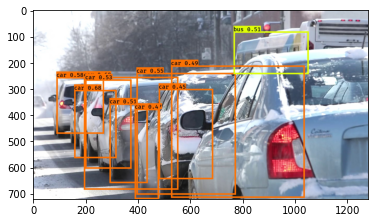

In [196]:
cap =  cv2.VideoCapture('traffic.mp4')
i = 0
 
while(cap.isOpened()):
    ret, frame = cap.read()
     
    # This condition prevents from infinite looping
    # incase video ends.
    if ret == False:
        break
     
    # Save Frame by Frame into disk using imwrite method
    cv2.imwrite('input/'+'Frame'+str(i)+'.jpg', frame)
    i += 1
cap.release()

folder_dir ="C:/Users/Niranjan/Desktop/Car detection for Autonomous Driving_1/input"
for images in os.listdir(folder_dir):
    out_scores, out_boxes, out_classes = predict(images)
def generate_video():
    image_folder = 'out/' # make sure to use your folder
    video_name = 'Trafic_annotated.avi'
      
    images = [img for img in os.listdir(image_folder)]
     
    # Array images should only consider
    # the image files ignoring others if any
    #print(images) 
  
    frame = cv2.imread(os.path.join(image_folder, images[0]))
  
    # setting the frame width, height width
    # the width, height of first image
    height, width, layers = frame.shape  
  
    video = cv2.VideoWriter(video_name, 0, 1, (width, height)) 
  
    # Appending the images to the video one by one
    for image in images: 
        video.write(cv2.imread(os.path.join(image_folder, image))) 
      
    # Deallocating memories taken for window creation
    video.release()  # releasing the video generated
  
  
# Calling the generate_video function
generate_video()


In [27]:
image_file = "0001.jpg"
print_info = True

Found 4 boxes for images/0001.jpg
car 0.46 (141, 308) (200, 334)
car 0.45 (637, 285) (726, 327)
car 0.35 (547, 296) (594, 316)
car 0.34 (674, 296) (723, 323)


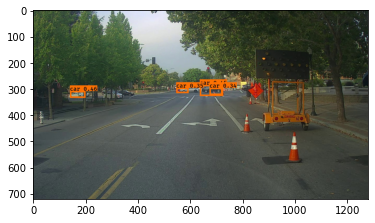

In [167]:
    image, image_data = preprocess_image("images/" + image_file, model_image_size = (608, 608))
    
    yolo_model_outputs = yolo_model(image_data) # It's output is of shape (m, 19, 19, 5, 85) 
    # But yolo_eval takes input a tensor contains 4 tensors: box_xy,box_wh, box_confidence & box_class_probs
    yolo_outputs = yolo_head(yolo_model_outputs, anchors, len(class_names))
    
    out_scores, out_boxes, out_classes = yolo_eval(yolo_outputs, [image.size[1],  image.size[0]], 10, 0.3, 0.5)

    if print_info:
        print('Found {} boxes for {}'.format(len(out_boxes), "images/" + image_file))
    # Generate colors for drawing bounding boxes.
    colors = get_colors_for_classes(len(class_names))
    # Draw bounding boxes on the image file
    #draw_boxes2(image, out_scores, out_boxes, out_classes, class_names, colors, image_shape)
    draw_boxes(image, out_boxes, out_classes, class_names, out_scores)
    # Save the predicted bounding box on the image
    image.save(os.path.join("out", str(image_file).split('.')[0]+"_annotated." +str(image_file).split('.')[1] ), quality=100)
    # Display the results in the notebook
    output_image = Image.open(os.path.join("out", str(image_file).split('.')[0]+"_annotated." +str(image_file).split('.')[1] ))
    imshow(output_image)

In [170]:
# import the modules


cap =  cv2.VideoCapture('video.mp4')
i = 0
 
while(cap.isOpened()):
    ret, frame = cap.read()
     
    # This condition prevents from infinite looping
    # incase video ends.
    if ret == False:
        break
     
    # Save Frame by Frame into disk using imwrite method
    cv2.imwrite('input/'+'Frame'+str(i)+'.jpg', frame)
    i += 1
 
cap.release()

# get the path or directory
folder_dir ="C:/Users/Niranjan/Desktop/Car detection for Autonomous Driving_1/input"
#folder_dir = 'C:\Users\Niranjan\Desktop\Car detection for Autonomous Driving_1\images'
#"C:/Users/RIJUSHREE/Desktop/Gfg images"
#C:/Users/Niranjan/Desktop/Car detection for Autonomous Driving_1/images
img = []
pic=[]
for images in os.listdir(folder_dir):
    image, image_data = preprocess_image('input/'+images, model_image_size = (608, 608))
    img.append(image_data)
    pic.append(image)



In [178]:
img1 = tf.concat(img,axis = 0)


TensorShape([108, 608, 608, 3])

In [ ]:
img1 = tf.concat(img,axis = 0)
yolo_model_outputs = yolo_model(img1)
yolo_outputs = yolo_head(yolo_model_outputs, anchors, len(class_names))

In [173]:
for i in range(yolo_model_outputs.shape[0]):
    yolo_output = (yolo_outputs[0][i:i+1,:,:,:,:],yolo_outputs[1][i:i+1,:,:,:,:],yolo_outputs[2][i:i+1,:,:,:,:],yolo_outputs[3][i:i+1,:,:,:,:])
    out_scores, out_boxes, out_classes = yolo_eval(yolo_output, [image.size[1],  image.size[0]], 10, 0.3, 0.5)
    colors = get_colors_for_classes(len(class_names))
    # Draw bounding boxes on the image file
    #draw_boxes2(image, out_scores, out_boxes, out_classes, class_names, colors, image_shape)
    draw_boxes(pic[i], out_boxes, out_classes, class_names, out_scores)
    # Save the predicted bounding box on the image
    pic[i].save(os.path.join("out", str(i)+"_annotated.jpg"), quality=100)
    # Display the results in the notebook
    #output_image = Image.open(os.path.join("out", str(i)+"_annotated.jpg"))
    #imshow(output_image)

car 0.46 (141, 308) (200, 334)
car 0.45 (637, 285) (726, 327)
car 0.35 (547, 296) (594, 316)
car 0.34 (674, 296) (723, 323)


In [88]:
img1 = tf.concat(img,axis = 0)

In [164]:
pici = np.array(img[0][0])

In [165]:
pici.shape

(608, 608, 3)

In [92]:
yolo_model_outputs = yolo_model(img1)

In [101]:
yolo_model_outputs.shape

TensorShape([123, 19, 19, 425])

In [106]:
yolo_model_outputs.shape[0]

123

In [102]:
yolo_outputs = yolo_head(yolo_model_outputs, anchors, len(class_names))

In [123]:
a = yolo_outputs[0]

In [131]:
yolo_outputs[0][3:4,:,:,:,:].shape

TensorShape([1, 19, 19, 5, 2])

In [148]:
a = (yolo_outputs[0][1:4,:,:,:,:],yolo_outputs[1][1:4,:,:,:,:])

In [149]:
type(a)

tuple

In [150]:
a[0].shape

TensorShape([3, 19, 19, 5, 2])

In [103]:
out_scores, out_boxes, out_classes = yolo_eval(yolo_outputs, [image.size[1],  image.size[0]], 10, 0.3, 0.5)

In [120]:
out_scores, out_boxes, out_classes = yolo_eval(yolo_outputs, [image.size[1],  image.size[0]], 10, 0.3, 0.5)

In [ ]:
yolo_output = (yolo_outputs[0][i:i+1,:,:,:,:],yolo_outputs[1][i:i+1,:,:,:,:],yolo_outputs[2][i:i+1,:,:,:,:],yolo_outputs[3][i:i+1,:,:,:,:])

In [145]:
for i in range(yolo_model_outputs.shape[0]):
    yolo_output = (yolo_outputs[0][i:i+1,:,:,:,:],yolo_outputs[1][i:i+1,:,:,:,:],yolo_outputs[2][i:i+1,:,:,:,:],yolo_outputs[3][i:i+1,:,:,:,:])
    out_scores, out_boxes, out_classes = yolo_eval(yolo_output, [image.size[1],  image.size[0]], 10, 0.3, 0.5)
    colors = get_colors_for_classes(len(class_names))
    # Draw bounding boxes on the image file
    #draw_boxes2(image, out_scores, out_boxes, out_classes, class_names, colors, image_shape)
    draw_boxes(, out_boxes, out_classes, class_names, out_scores)
    # Save the predicted bounding box on the image
    image.save(os.path.join("out", str(i)+"_annotated.jpg"), quality=100)
    # Display the results in the notebook
    output_image = Image.open(os.path.join("out", str(i)+"_annotated.jpg"))
    #imshow(output_image)


car 0.46 (141, 308) (200, 334)
car 0.45 (637, 285) (726, 327)
car 0.35 (547, 296) (594, 316)
car 0.34 (674, 296) (723, 323)
car 0.46 (141, 308) (200, 334)
car 0.45 (637, 285) (726, 327)
car 0.35 (547, 296) (594, 316)
car 0.34 (674, 296) (723, 323)
car 0.46 (141, 308) (200, 334)
car 0.45 (637, 285) (726, 327)
car 0.35 (547, 296) (594, 316)
car 0.34 (674, 296) (723, 323)
car 0.46 (141, 308) (200, 334)
car 0.45 (637, 285) (726, 327)
car 0.35 (547, 296) (594, 316)
car 0.34 (674, 296) (723, 323)
car 0.46 (141, 308) (200, 334)
car 0.45 (637, 285) (726, 327)
car 0.35 (547, 296) (594, 316)
car 0.34 (674, 296) (723, 323)
car 0.46 (141, 308) (200, 334)
car 0.45 (637, 285) (726, 327)
car 0.35 (547, 296) (594, 316)
car 0.34 (674, 296) (723, 323)
car 0.46 (141, 308) (200, 334)
car 0.45 (637, 285) (726, 327)
car 0.35 (547, 296) (594, 316)
car 0.34 (674, 296) (723, 323)
car 0.46 (141, 308) (200, 334)
car 0.45 (637, 285) (726, 327)
car 0.35 (547, 296) (594, 316)
car 0.34 (674, 296) (723, 323)
car 0.46

car 0.45 (637, 285) (726, 327)
car 0.35 (547, 296) (594, 316)
car 0.34 (674, 296) (723, 323)
car 0.46 (141, 308) (200, 334)
car 0.45 (637, 285) (726, 327)
car 0.35 (547, 296) (594, 316)
car 0.34 (674, 296) (723, 323)
car 0.46 (141, 308) (200, 334)
car 0.45 (637, 285) (726, 327)
car 0.35 (547, 296) (594, 316)
car 0.34 (674, 296) (723, 323)
car 0.46 (141, 308) (200, 334)
car 0.45 (637, 285) (726, 327)
car 0.35 (547, 296) (594, 316)
car 0.34 (674, 296) (723, 323)
car 0.46 (141, 308) (200, 334)
car 0.45 (637, 285) (726, 327)
car 0.35 (547, 296) (594, 316)
car 0.34 (674, 296) (723, 323)
car 0.46 (141, 308) (200, 334)
car 0.45 (637, 285) (726, 327)
car 0.35 (547, 296) (594, 316)
car 0.34 (674, 296) (723, 323)
car 0.46 (141, 308) (200, 334)
car 0.45 (637, 285) (726, 327)
car 0.35 (547, 296) (594, 316)
car 0.34 (674, 296) (723, 323)
car 0.46 (141, 308) (200, 334)
car 0.45 (637, 285) (726, 327)
car 0.35 (547, 296) (594, 316)
car 0.34 (674, 296) (723, 323)
car 0.46 (141, 308) (200, 334)
car 0.45

In [83]:
img = tf.concat([images for images in img1],axis=0)

In [84]:
img.shape

TensorShape([123])

In [153]:
img[0][0].shape

(608, 608, 3)

In [ ]:
    if print_info:
        print('Found {} boxes for {}'.format(len(out_boxes), "images/" + image_file))
    # Generate colors for drawing bounding boxes.
    colors = get_colors_for_classes(len(class_names))
    # Draw bounding boxes on the image file
    #draw_boxes2(image, out_scores, out_boxes, out_classes, class_names, colors, image_shape)
    draw_boxes(image, out_boxes, out_classes, class_names, out_scores)
    # Save the predicted bounding box on the image
    image.save(os.path.join("out", str(image_file).split('.')[0]+"_annotated." +str(image_file).split('.')[1] ), quality=100)
    # Display the results in the notebook
    output_image = Image.open(os.path.join("out", str(image_file).split('.')[0]+"_annotated." +str(image_file).split('.')[1] ))
    imshow(output_image)